In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-04-21 17:59:52.098169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Neural Network on PCA Results

In [2]:
# Directory where PCA results are saved
pca_dir = "../../data/pca_data/byBasin_pca"
result_dir = "../../data/performance_comparison"

# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withPCA"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Get a list of all PCA result files
pca_files = [f for f in os.listdir(pca_dir) if f.endswith('_pca_with_target.csv')]

# Dictionary to store results for each basin
results = {}

# Process each PCA result file
for file in pca_files:
    basin_name = file.replace('_pca_with_target.csv', '').replace(' ', '_')  # Replace spaces with underscores
    sanitized_basin_name = basin_name.replace(' ', '_')  # Sanitize basin name for file paths
    pca_df = pd.read_csv(f"{pca_dir}/{file}")

    # Separate data with known and unknown 'Li' values
    known_data = pca_df.dropna(subset=['Li'])
    unknown_data = pca_df[pca_df['Li'].isnull()]

    # Prepare training and testing data from known data
    principal_components = [f'PC{i+1}' for i in range(10)]  # Use the first 10 principal components
    X_known = known_data[principal_components]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin_name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Explained Variance': explained_variance}
    print(f"Basin: {sanitized_basin_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect prediction
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {sanitized_basin_name}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin_name}_actual_predicted_neural_network_pca.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[principal_components]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred

        pca_df.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Save predicted data for unknown values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin_name}_predicted_Li_neural_network_pca.csv")
        pca_df.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {sanitized_basin_name}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin_name}_neural_network_predicted_distribution.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_with_pca = pd.DataFrame(results).T
nn_results_df_with_pca.to_csv(os.path.join(result_dir, "neural_network_performance_PCA.csv"), index_label='Basin')

print("Saved performance metrics with PCA to CSV.")

/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Basin: Rocky_Mountain - MSE: 36.80101222581736, R2: 0.828446818564765, MAE: 3.2289408664759116, RMSE: 6.066383784909867, Explained Variance: 0.8286995599446894
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step 


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Basin: Fort_Worth - MSE: 116.9235725578725, R2: 0.9045938547877304, MAE: 6.0444653129577635, RMSE: 10.813120389502398, Explained Variance: 0.9228906049844413
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Basin: Illinois - MSE: 95.33876336501551, R2: 0.5013662586655054, MAE: 6.264798103332519, RMSE: 9.764157073962684, Explained Variance: 0.5227090287588663
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Basin: Gulf_Coast - MSE: 787.032336660803, R2: 0.8608580697406526, MAE: 15.092471376434036, RMSE: 28.054096611026402, Explained Variance: 0.8631541578720641
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Basin: Michigan - MSE: 150.50732435580383, R2: 0.6234732265951083, MAE: 8.505547228177388, RMSE: 12.268142661210124, Explained Variance: 0.6234734238892403
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Basin: Pacific - MSE: 3.7780141219590644, R2: 0.6351601084354603, MAE: 1.1148895950975088, RMSE: 1.9437114297032532, Explained Variance: 0.6550690894463933
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Basin: Permian - MSE: 4630.911391209812, R2: 0.08933045596357769, MAE: 15.100616710861935, RMSE: 68.0508000776612, Explained Variance: 0.10580935198931762
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Basin: Williston - MSE: 330.01804660098213, R2: 0.8568180686161222, MAE: 11.360038293054709, RMSE: 18.16639883413832, Explained Variance: 0.8569307133444056
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Basin: Great_Plains - MSE: 39050.665284698094, R2: -0.046731978678561825, MAE: 56.63023033655607, RMSE: 197.61241176782923, Explained Variance: 0.03452991298122399
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Basin: Appalachian - MSE: 1295.181943823384, R2: 0.6455079041689071, MAE: 24.57179313117311, RMSE: 35.98863631513959, Explained Variance: 0.6560950427663061
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Basin: Oklahoma_Platform - MSE: 190.07568482525687, R2: 0.3949090337971255, MAE: 9.169298993278952, RMSE: 13.786793855906343, Explained Variance: 0.40838414051902305
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Basin: Anadarko - MSE: 1816.9498811333306, R2: 0.8174853163339403, MAE: 14.833571844100952, RMSE: 42.62569508094068, Explained Variance: 0.8211072472797291
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1656070861.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Saved performance metrics with PCA to CSV.


### Neural Network on Imputed Data without PCA

In [3]:
# Load the dataset with all basins
df = pd.read_csv("../../data/df_output/df_cleaned_imputed.csv")


# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withoutPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withoutPCA"
result_dir="../../data/performance_comparison"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Define features to use for predicting 'Li'
predictors = ['B', 'Ba', 'Br', 'HCO3', 'FeTot', 'K', 'Na', 'Cl', 'SO4', 'Mg', 'Ca', 'Sr', 'Zn', 'TDS', 'DEPTHUPPER']

# Dictionary to store results for each basin
results = {}

# Loop through each unique basin category
for basin in df['BASIN_CATEGORY'].unique():
    sanitized_basin = basin.replace(' ', '_')  # Replace spaces with underscores
    print(f"Processing Gradient Boosting for {basin}")
    df_basin = df[df['BASIN_CATEGORY'] == basin]

    # Separate data with known and unknown 'Li' values
    known_data = df_basin.dropna(subset=['Li'])
    unknown_data = df_basin[df_basin['Li'].isnull()]

    # Prepare training and testing data from known data
    X_known = known_data[predictors]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Explained Variance': explained_variance
    }
    print(f"Basin: {basin} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {basin}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin}_actual_predicted_neural_network_no_pca.png")
    plt.savefig(plot_path)
    plt.close()


    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[predictors]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred

        # Merge the predictions back to the main DataFrame
        df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Optional: to also show original 'Li' in the same column where available
        df_basin.loc[known_data.index, 'Predicted_Li'] = known_data['Li']

        # Save the full basin DataFrame including both known 'Li' and predicted 'Li' values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin}_predicted_Li_neural_network_no_pca.csv")
        df_basin.to_csv(predicted_data_path, index=False)


        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin}_predicted_distribution_neural_network_no_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_without_pca = pd.DataFrame(results).T
nn_results_df_without_pca.to_csv(os.path.join(result_dir, "neural_network_performance_no_pca.csv"), index_label='Basin')

print("Saved performance metrics without PCA to CSV.")

Processing Gradient Boosting for Appalachian


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Basin: Appalachian - MSE: 26088.12823170028, R2: -6.140336766790841, MAE: 79.48431376442656, RMSE: 161.5181978344864, Explained Variance: -5.295420182199534
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Permian


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Basin: Permian - MSE: 18400.14546602937, R2: -2.618391859874312, MAE: 63.861276656278626, RMSE: 135.64713585634374, Explained Variance: -1.9961933434172279
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Oklahoma Platform


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Basin: Oklahoma Platform - MSE: 44518.926302706146, R2: -140.72249415060142, MAE: 70.94858568664858, RMSE: 210.99508596814795, Explained Variance: -139.92297804066914
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Gulf Coast


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Basin: Gulf Coast - MSE: 2546.612677445154, R2: 0.5497763089811162, MAE: 32.82054689709162, RMSE: 50.46397405521244, Explained Variance: 0.5573762301166263
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Williston


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Basin: Williston - MSE: 3119.106303672156, R2: -0.3532583122382442, MAE: 39.91143896124142, RMSE: 55.84895973670554, Explained Variance: -0.33281760323997034
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Michigan


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Basin: Michigan - MSE: 13114.29219110618, R2: -31.80825132824019, MAE: 91.73590267435709, RMSE: 114.51765012916647, Explained Variance: -21.897704218167913
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Pacific


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Basin: Pacific - MSE: 1128.4430113661404, R2: -107.97286580022109, MAE: 23.745549948462124, RMSE: 33.59230583580324, Explained Variance: -107.81727864163014
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Illinois


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Basin: Illinois - MSE: 52719.07263419869, R2: -274.72739040709695, MAE: 161.86103925323488, RMSE: 229.6063427568992, Explained Variance: -209.8635198463942
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Great Plains


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Basin: Great Plains - MSE: 27476.340422373614, R2: 0.26351154410609845, MAE: 84.509182707163, RMSE: 165.75988785702532, Explained Variance: 0.28339511836612463
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Anadarko


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Basin: Anadarko - MSE: 9516.412019862151, R2: 0.04406558074257949, MAE: 67.59403836502219, RMSE: 97.55209900285155, Explained Variance: 0.24717961952055756
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Rocky Mountain


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Basin: Rocky Mountain - MSE: 3706.227048917174, R2: -16.27710741926317, MAE: 25.73142756825728, RMSE: 60.87878981153596, Explained Variance: -15.567535803617154
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Fort Worth


/Users/brittanysmacbookair/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Basin: Fort Worth - MSE: 216638.04765265022, R2: -175.77018056064958, MAE: 338.9869401550293, RMSE: 465.44392535798573, Explained Variance: -167.35453847408866
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
/var/folders/0k/8xgs2x552ss9yf4mxj5lc0000000gn/T/ipykernel_88697/1825023066.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Saved performance metrics without PCA to CSV.


## Performance Comparison

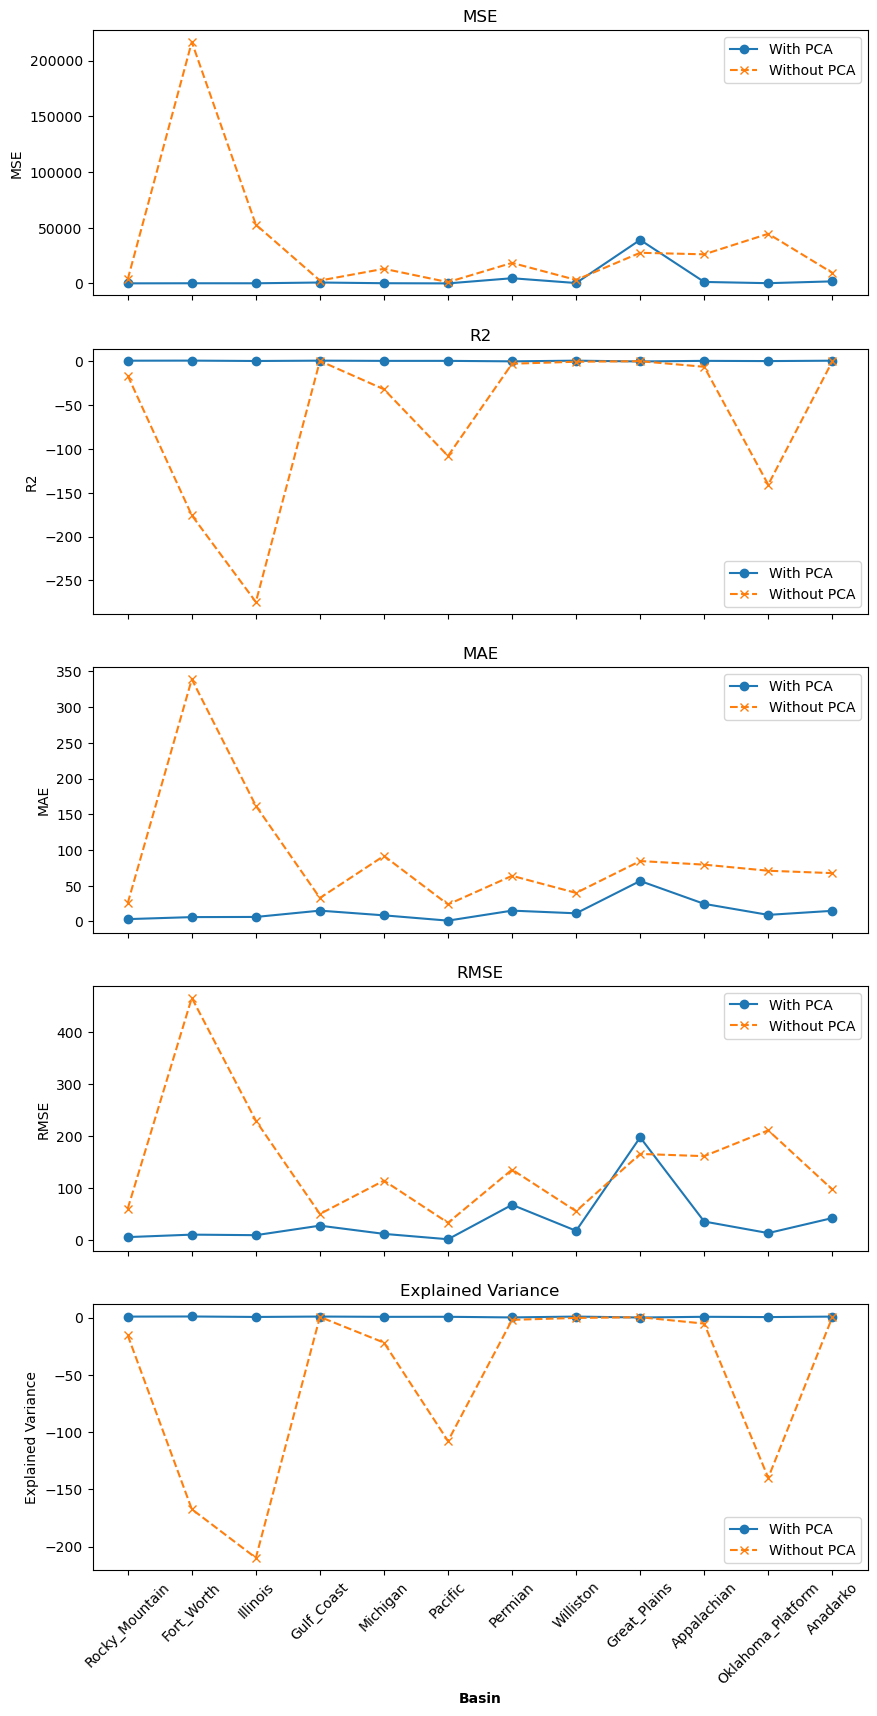

In [4]:
# Load results DataFrames
nn_results_df_with_pca = pd.read_csv("../../data/performance_comparison/neural_network_performance_pca.csv")
nn_results_df_without_pca = pd.read_csv("../../data/performance_comparison/neural_network_performance_no_pca.csv")

# Replace spaces with underscores in the basin names
nn_results_df_with_pca['Basin'] = nn_results_df_with_pca ['Basin'].str.replace(' ', '_')
nn_results_df_without_pca['Basin'] = nn_results_df_without_pca['Basin'].str.replace(' ', '_')

# Set 'Basin' as index now that the names are sanitized
nn_results_df_with_pca .set_index('Basin', inplace=True)
nn_results_df_without_pca.set_index('Basin', inplace=True)

# Merge the two results DataFrames
nn_combined_results = nn_results_df_with_pca.join(nn_results_df_without_pca, lsuffix='_with_pca', rsuffix='_without_pca')

# Define the metrics to compare
metrics = ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance']

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 20), sharex=True)

# Plot comparisons for each metric
for idx, metric in enumerate(metrics):
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_with_pca'], marker='o', label='With PCA', linestyle='-')
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_without_pca'], marker='x', label='Without PCA', linestyle='--')
    
    axs[idx].set_ylabel(metric)
    axs[idx].set_title(metric)
    axs[idx].legend()

# Set common labels
plt.xlabel('Basin', fontweight='bold')
plt.xticks(rotation=45)
plt.savefig("../../images/performance_comparison_plots/neural_network_performance_comparison.png")